# Working with your team data
> "Excel at Python"

- author: <a href=https://www.linkedin.com/in/dmytrokarabash/>Dmytro Karabash</a>, <a href=http://maximk.com//>Maxim Korotkov</a> 
- categories: [management, python]
- image: images/unsplash-scott-graham-5fNmWej4tAA-640.jpg
- permalink: /teamdata/

In [1]:
# hide
# loading functions

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

verbosity = 5

pd.options.display.max_rows = 7


## Introduction

You’re a boss now. You have a team or a business unit doing consultancy. Probably a bunch of Consultants helping clients, some Project Managers leading your projects in a nice Agile or whatever way. Everyone fills their timesheets (and you cut their bonuses if they don’t) – the time is billed to clients, and you have Fixed Fee projects as well. Maybe smaller teams being parts of your organization also – you can lead ten, a hundred or a thousand people (hey, dude – you run a unit of 1000 employees? Don’t read this article – hire someone who did). You probably even have an ERP or something and a CFO in a lovely corner office. Do you have an excellent way to estimate how much profit every team member and project brings and ways to predict it with reasonable precision? If you have a decent ERP dashboard which gives you all that – then you’re lucky, and you don’t need this article either. The chances are that you get a simple calculation end of the year – like “let’s take all revenue finance recognized on your projects in a year and man day cost at USD 800 to get your unit profitability”. USD 800 can seem crazily high or unacceptably low, depending on the business you’re in. So that’s the precision you have to count the money your team brings to the firm? Do we need to remind you that this is one of the reasons why your job exists?

What else can you get? All the timesheets projects with their budgets, and you can even get to approximate costs (let’s discuss it later) — a shitload of data for a year, even for a team of 10. What we show is that you don’t need an ERP to do the rest – the notebook in Jupyter will do. Keep this in mind - management starts with measurement. How can you supervise your team and projects if you don’t have their data at your fingers?

Why do you need Data Science here? Well, you can have all data at your fingers. Eventually, you would want to calculate your profit like
```python
profit = revenue - cost
```

Not only as subtracting two numbers, but also on the level of tables - so the output of the above statement can be a table with profit per consultant per month, like this:

In [2]:
# hide
profit = pd.DataFrame([[6187.500, 8006.25], [8050.000, 3762.50]],
                      index=['CATHY THE NEW MANAGER', 'FRANK THE CONSTULANT'],
                      columns=['2020-02', '2020-03'])
# next a bit of formating
profit = profit.applymap(lambda x: "{:10.2f}".format(x))

In [3]:
profit

,2020-02,2020-03
CATHY THE NEW MANAGER,6187.50,8006.25
FRANK THE CONSTULANT,8050.00,3762.50


Or get list of 3 people with most billable hours in March via following statement
```python
t.where(t['Billable'] & (t['month'] == '2020-03')
        ).groupby(['User'])['effort'].sum().nlargest(3)
```

The code above is indeed not executable, but we promise to get you there in a few paragraphs. And yes, there is some learning of python required. The huge difference from anything else you’ve been doing yourself (ERP reports, Excel, other tools) is that any analysis stays in the notebook and can be re-applied after your data changes.

## Data Science

So, let’s get this done. First – yes, you need to know a bit of python to get the files in. The basic level will do. If you are a manager in 2020 and can’t write a simple script – hmm, you probably missed something. The objective is not to build an ERP and not even to have an easy-to-use toolkit - we want to show you how to make a toolkit for yourself (but feel free to reuse our code). What you will see is a straightforward set of examples - spend an hour or two to load your files into the notebook and then start playing with it - just make the analysis you want. You can end up checking a few numbers or building your charts and dashboards. It is ok, even if you work for a corporation (that’s where you need it most) - just install Anaconda and download the notebook. So, we first get and transform our input files (if you want to follow text AND all the code - read it on colab). 

We are loading projects, timesheets, and roles below - more details will follow on what we presumed is inside. Note - files are loaded from the GitHub repository so that they will open in colab or your local machine just the same.	

In [4]:
data = {}
data_path = 'https://raw.githubusercontent.com/h17/fastreport/master/data/'
url = data_path + 'roles.csv'
data['roles'] = pd.read_csv(url, index_col=0, sep=";")

url = data_path + 'project_data.xlsm'
project_data = pd.ExcelFile(url)
project_data.sheet_names

['TS Feb', 'TS Mar', 'TS Apr', 'Projects', 'Employees']

Don’t focus too much on the next code block - we have monthly timesheets in separate tabs and need to stack them one on top of another. Plus - we have errors in excel (Sat.1 column) - data cleanup is also required, quite usual for those who touched data science. Collapsed blocks in our notebook contain the code, which is not critical for understanding. If you’d rather read it all, we suggest you switch to either GitHub or colab, so you can also play with it.

In [5]:
# collapse

timesheets = []
for sheet in project_data.sheet_names:
    if 'TS' in sheet:
        timesheets += [pd.read_excel(project_data, sheet, header=2)]
    else:
        tmp = pd.read_excel(project_data, sheet)
        data[sheet] = tmp
if 'Sat.1' in timesheets[0]:  # cleaning from Sat.1
    timesheets[0] = timesheets[0].rename(
        columns={'Sat': 'Sun', 'Sat.1': 'Sat'})
data['timesheet'] = pd.concat(timesheets, sort=False)
d = {'Billable': True, 'Non-Billable': False}
data['timesheet']['Billable'] = data['timesheet']['Billing'].replace(d)
data['timesheet'].drop(['Billing'], axis=1, inplace=True)
data['timesheet'] = data['timesheet'][~data['timesheet'].User.isnull()]


So, let's see what we've got here:

In [6]:
data.keys()
for key in data.keys():
    string_format = "{:20} shape: {:>10} rows \t and {:>10} columns"
    print(string_format.format(key, *data[key].shape))

dict_keys(['roles', 'Projects', 'Employees', 'timesheet'])

roles                shape:          8 rows 	 and          4 columns
Projects             shape:         48 rows 	 and         10 columns
Employees            shape:         35 rows 	 and          5 columns
timesheet            shape:       1792 rows 	 and         14 columns


## Data we loaded

Let us summarize it here – most probably if you are a team leader or business unit manager – you can get
* Dictionaries
    * Cost per region or default cost for “outside” contributors
    * Average revenue per hour for projects not “owned” by you
    

In [7]:
# show roles
roles = data["roles"]
roles

,Seniority,EU,US,UK
Position,,,,
Unit Head,SENIOR,1100,1300,1200
Program Manager,EXPERIENCED,900,1000,900
Project Manager,SENIOR,800,800,800
...,...,...,...,...
Consultant,SENIOR,800,800,900
Consultant,EXPERIENCED,550,550,550
Consultant,JUNIOR,500,500,500


We need to set default values and bring it to format easy to use, which is very easy in python:

In [8]:
default_revenue = 1200
default_cost = 850

# wide to long format
roles_long = pd.melt(roles.reset_index(),
                     id_vars=['Position', 'Seniority'],
                     var_name='region',
                     value_name='cost')
roles_long

,Position,Seniority,region,cost
0,Unit Head,SENIOR,EU,1100
1,Program Manager,EXPERIENCED,EU,900
2,Project Manager,SENIOR,EU,800
...,...,...,...,...
21,Consultant,SENIOR,UK,900
22,Consultant,EXPERIENCED,UK,550
23,Consultant,JUNIOR,UK,500


* HeadCount
    * List of your employees, with their grades (or costs)
    * Engagement model (employee or contractor)

In [9]:
# show head count
headcount = data["Employees"]
headcount = headcount.merge(
    roles_long[['Position', 'Seniority', 'region', 'cost']],
    how='left',
    left_on=['Seniority', 'Position', 'Country'],
    right_on=['Seniority', 'Position', 'region'])
headcount['cost'] = headcount['cost'].fillna(default_cost)
headcount

,Name,Engagement,Country,Position,Seniority,region,cost
0,JANE DOE,STAFF,US,Consultant,EXPERIENCED,US,550.0
1,JOHN DOE,STAFF,FR,Consultant,JUNIOR,NaN,850.0
2,JOHN SMITH,STAFF,US,Consultant,EXPERIENCED,US,550.0
...,...,...,...,...,...,...,...
32,JOHN THE CONSULTANT,STAFF,FR,Consultant,EXPERIENCED,NaN,850.0
33,JANE THE MANAGER,CONTRACTOR,BE,Project Manager,SENIOR,NaN,850.0
34,JACK THE EXPERT,STAFF,BE,Consultant,SENIOR,NaN,850.0


* Projects with budgets, effort estimates, dates, types of revenue recognition (Time and Material, Fixed Fee or something else), et cetera

In [10]:
# show projects

projects = data["Projects"]
projects

,Client ID,Project ID,Project,PM,Region,Start,End,Funding,Daily Rate,TCV
0,13154,68454,Medium consutancy 1,SUSAN THE MANAGER,Europe,2019-01-16 08:00:00,2020-07-22 14:00:00,Time and Materials,1200,"39,000 USD"
1,2764,70285,Our biggest project,EXT 6a8e0ca747,Europe,2019-10-01 08:00:00,2021-04-30 11:00:00,Time and Materials,1200,"1,450,000 USD"
2,12916,68093,Upgrade to new version,TIM THE LEAVER,Europe,2018-09-28 08:00:00,2020-04-27 17:00:00,Fixed Fee,1200,"127,500 USD"
...,...,...,...,...,...,...,...,...,...,...
45,12899,63852,Huge consultancy pool,JACK THE MANAGER,Europe,2017-08-01 08:00:00,2020-04-27 17:00:00,Time and Materials,1200,"198,000 USD"
46,12901,71248,Small upgrade,JACK THE MANAGER,Europe,2020-01-29 08:00:00,2020-12-31 17:00:00,Time and Materials,1200,"108,000 USD"
47,17719,70618,Small consultancy pool,SUSAN THE MANAGER,Europe,2019-11-06 08:00:00,2020-06-30 17:00:00,Time and Materials,1200,"27,200 USD"


* Timesheets for your team / your projects. It is possible that other teams can contribute to your projects and your team might work in outside projects 
    * Typically arrive monthly or weekly
    * (optional) Planned effort
        * There might be none, in one of the next posts we'll talk about autofill

In [11]:
# show timesheets

timesheet = data["timesheet"]
timesheet

,Project,Activity,User,Period Starting,Effort Type,Total (Days),Sun,Mon,Tue,Wed,Thu,Fri,Sat,Billable
0,PRJ f74fe3647d,Consultancy,EXT 800982ab08,2020-02-02,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
1,PRJ f74fe3647d,Consultancy,EXT c8c92ca432,2020-02-02,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
2,PRJ f74fe3647d,Consultancy,EXT c8c92ca432,2020-02-09,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,PRJ 67df00a7e9,Consultancy,EXT ca02603616,2020-04-12,Actual,1.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,True
621,PRJ 67df00a7e9,Consultancy,EXT ca02603616,2020-04-19,Actual,1.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,True
622,PRJ 67df00a7e9,Consultancy,EXT ca02603616,2020-04-26,Reported,1.5,0.0,0.5,0.5,0.0,0.5,NaN,NaN,True


EXT users here are outside of our headcount (let’s say we are not getting the real names, but rather some ids from ERP in such case)

Why not just have things done by ERP? Your ERP probably does not present you anything nicely in terms of parameters you’d want to control on your level (otherwise, you won’t read this anyway). There may be a project running to improve it by 2025 - maybe one of the Big4 firms is interviewing you for requirements. If you are steering this boat long enough – you might have ended up with quick and dirty calculation, SQL queries to SAP (with field names still in German), or an Excel file. Why? Your bosses don’t care – they already hired you, and a better ERP is coming in 2025 anyway. So they want to know how much money your team makes (preferably - per person, per month, per project, with charts, projections, and comparisons) and to know why it is not so profitable (because it never is).

To simplify your way forward we are going to create a timeseries out of timesheets which is a bit more involved so you can skip it for now and come back to it later, but the point is that at the end you will get a lovely monthly pandas DataFrame that looks like this

In [12]:
# collapse

dd = []
timesheet['Period Starting'] = pd.to_datetime(timesheet['Period Starting'])
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for i, weekday in enumerate(weekdays):
    columns = [col for col in timesheet if col not in weekdays or col == weekday]
    tmp = timesheet[columns].copy()
    tmp = tmp.rename(columns={weekday: 'effort'})
    tmp['date'] = tmp['Period Starting']+pd.to_timedelta('{}D'.format(i))
    tmp['weekday'] = weekday
    tmp = tmp.drop(['Period Starting', 'Total (Days)'], axis=1)
    dd += [tmp]

timeseries = pd.concat(dd, sort=False).sort_values(['User', 'date'])
timeseries = timeseries.reset_index().drop('index', axis=1)
timeseries['date'] = pd.to_datetime(timeseries['date']).astype('str')
timeseries['month'] = timeseries['date'].str[:7]

def isweekend(x): return x in ['Sun', 'Sat']

timeseries['weekend'] = timeseries['weekday'].apply(isweekend)
timeseries['workweek'] = ~timeseries['weekday'].apply(isweekend)
timeseries

,Project,Activity,User,Effort Type,effort,Billable,date,weekday,month,weekend,workweek
0,Upgrade in two contracts - 1,Consultancy,CATHY THE NEW MANAGER,Actual,0.0,True,2020-02-16,Sun,2020-02,True,False
1,Upgrade in two contracts - 2,Consultancy,CATHY THE NEW MANAGER,Actual,0.0,True,2020-02-16,Sun,2020-02,True,False
2,A pilot for huge opportunity,Consultancy,CATHY THE NEW MANAGER,Actual,0.0,True,2020-02-16,Sun,2020-02,True,False
...,...,...,...,...,...,...,...,...,...,...,...
12541,Strategic project in a new region,Project Management,TOM THE TEAM LEADER,Reported,NaN,True,2020-05-01,Fri,2020-05,False,True
12542,Strategic project in a new region 2,Consultancy,TOM THE TEAM LEADER,Actual,NaN,False,2020-05-02,Sat,2020-05,True,False
12543,Strategic project in a new region,Project Management,TOM THE TEAM LEADER,Reported,NaN,True,2020-05-02,Sat,2020-05,True,False


It is common in data science to have one big DataFrame (similar to excel tab or SQL table) that you can group and filter easily. It is helpful because it makes things very easy.

## Profitability

Timesheets and project budgets are simplified this way, and you can manipulate them the way you want in a few simple statements. If you studied excel formulas - you could do this also. Now, let’s look at profitability in the most straightforward manner possible. As a manager, we suggest you do that to set benchmarks for your team. So, profit is $$\mbox{Revenue  –  Cost}$$ and we intend to keep it simple. You can implement the calculations you like. 

**Revenue**: Let’s say that for a Time & Material project, you generate as much revenue as you bill (on agreed rate) up to its budget. We are not doing any Fixed Fee recognition formula. Different companies do it differently, and you’ll either need historical data or actual recognized value depending on how you operate.

We also assume that we are interested only by users in our headcount (so we filter out all EXT users).

In [13]:
# revenue calculation for a person for a month 
# (SUM REV of all timesheet records * corresp project rates)
revenue_df = timeseries[['User', 'Project',
                         'Billable', 'effort', 'date', 'month']]
revenue_df = revenue_df.merge(projects[['Project', 'Daily Rate']],
                              how='left',
                              on='Project')
revenue_df['Daily Rate'].fillna(default_revenue, inplace=True)
revenue_df = revenue_df[(revenue_df['User'].str[:3] != 'EXT') &
                        (revenue_df['Billable'])]

revenue_df['daily_revenue'] = revenue_df['Daily Rate'] * \
    revenue_df['effort']
revenue = revenue_df.groupby(['User', 'month'])[
    'daily_revenue'].sum().unstack().fillna(0)
revenue = revenue[revenue.sum(1) > 0]
revenue.head()

month,2020-02,2020-03,2020-04,2020-05
User,,,,
CATHY THE NEW MANAGER,11550.000,19350.00,9412.500,0.0
FRANK THE CONSTULANT,15750.000,12425.00,14875.000,0.0
IVAN THE PROGRAMMER,25062.500,29043.75,25643.750,0.0
JACK THE EXPERT,29093.750,31331.25,24843.750,0.0
JACK THE MANAGER,24090.625,22318.75,18821.875,0.0


We got revenue per month per person. Not too sophisticated, right?

**Cost**: Let’s start with the fact that just using the “default cost rate” is not enough - whenever margins are under pressure, you should do better. You might have people working in different countries and of totally different levels. Talk to your finance team and get some estimates from them (or make it together). We’d say they owe you that much if you were appointed to run a team or business unit. We will assume below that you managed to get a few grades per Country (see _roles_). Costs per individual will be nice to have as well. The beauty of this tool (compared to doing Excel by yourself) is that you can just add it - it will be a few lines of code. Let’s calculate direct cost per month: here we check the cost of effort posted on timesheets, presuming they are full - can check per number of working days in a month also and compare. We are not interested in external resources, so we’ll filter them out again.

In [14]:
headcount

,Name,Engagement,Country,Position,Seniority,region,cost
0,JANE DOE,STAFF,US,Consultant,EXPERIENCED,US,550.0
1,JOHN DOE,STAFF,FR,Consultant,JUNIOR,NaN,850.0
2,JOHN SMITH,STAFF,US,Consultant,EXPERIENCED,US,550.0
...,...,...,...,...,...,...,...
32,JOHN THE CONSULTANT,STAFF,FR,Consultant,EXPERIENCED,NaN,850.0
33,JANE THE MANAGER,CONTRACTOR,BE,Project Manager,SENIOR,NaN,850.0
34,JACK THE EXPERT,STAFF,BE,Consultant,SENIOR,NaN,850.0


In [15]:
# cost calculation for a project 
# (SUM COST of all timesheet records * corresp cost rates - see roles)
cost_df = timeseries[['User', 'Project', 'effort', 'date', 'month']]
cost_df = cost_df.merge(headcount[['Name', 'cost']],
                        how='left', left_on='User', right_on='Name')
cost_df = cost_df[cost_df['User'].str[:3] != 'EXT']
cost_df['daily_cost'] = cost_df['cost'] * cost_df['effort']
cost = cost_df.groupby(['User', 'month'])['daily_cost'].sum()
cost = cost.unstack().fillna(0)
cost = cost[cost.sum(1) > 0]
cost.head()

month,2020-02,2020-03,2020-04,2020-05
User,,,,
CATHY THE NEW MANAGER,5362.500,11343.750,9332.8125,0.0
FRANK THE CONSTULANT,7700.000,8662.500,7768.7500,0.0
IVAN THE PROGRAMMER,11481.250,12925.000,11618.7500,0.0
JACK THE EXPERT,19921.875,21621.875,18168.7500,0.0
JACK THE MANAGER,11800.000,10900.000,9600.0000,0.0


Now, we can get to profit per user per month using operations on dataframes. And here it bears some fruit. _Profit = revenue - cost_. Indeed, it required some data cleanup first - but not too much

In [16]:
profit = revenue - cost
profit.head()

month,2020-02,2020-03,2020-04,2020-05
User,,,,
CATHY THE NEW MANAGER,6187.500,8006.250,79.6875,0.0
FRANK THE CONSTULANT,8050.000,3762.500,7106.2500,0.0
IVAN THE PROGRAMMER,13581.250,16118.750,14025.0000,0.0
JACK THE EXPERT,9171.875,9709.375,6675.0000,0.0
JACK THE MANAGER,12290.625,11418.750,9221.8750,0.0


That's what we've promised, right? Ok, second one - people who entered most Billable hours in March

In [17]:
t = timeseries  # concatenating just in case you are reading from phone
t.where(t['Billable'] & (t['month'] == '2020-03')
        ).groupby(['User'])['effort'].sum().nlargest(3)

User
TOM THE EXPERT       26.7500
JACK THE EXPERT      25.3125
PHILIP THE EXPERT    24.8750
Name: effort, dtype: float64

## What else?

Now let’s look at how to apply some python and data science techniques (we will get to more details in our next posts) to data you’ve seen above and how to visualize it nicely.

First, let’s take a PM and visualize revenue on his/her projects per month.

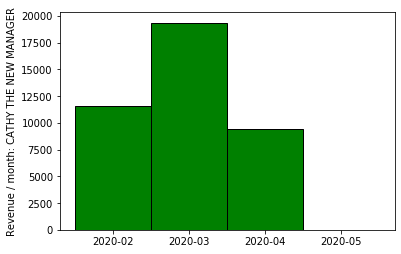

In [18]:
%matplotlib inline

pm_selected = "CATHY THE NEW MANAGER"
drawdt = revenue.loc[pm_selected].T

plt.bar(range(len(drawdt.index)), drawdt.values, color="green",
        width=1, align='center', edgecolor='black');
plt.xticks(range(len(drawdt.index)), drawdt.index);
plt.ylabel("Revenue / month: "+pm_selected);

That was simple. Then, some fun for those who know slightly more advanced python - you can make an interactive chart in few lines, e.g., here we want to make it visual in terms of if the value is above or below the benchmark (works if you copy notebook, is not clickable on the blog)

<IPython.core.display.Javascript object>


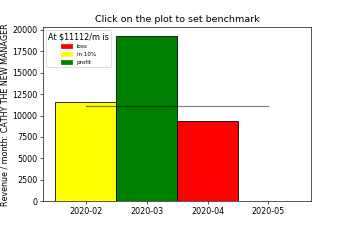

In [21]:
# collapse

%matplotlib notebook

# colors of bars
def get_colors(v):
    colors = []
    for i in range(len(drawdt.index)):
        color = "yellow"
        if (drawdt[i] < v*0.9):
            color = "red"
        if (drawdt[i] > v*1.1):
            color = "green"
        colors.append(color)
    return colors

# plot drawing
def plt_all(isdef, yvalue):
    if isdef:
        bcolors = "white"
        xtitle = 'Set value'
    else:
        a = np.empty(len(drawdt.index))
        a.fill(yvalue)
        plt.plot(range(len(drawdt.index)), a, color="black", alpha=0.5)
        bcolors = get_colors(yvalue)
        xtitle = 'At ${:.0f}/m is'.format(yvalue)
    plt.bar(range(len(drawdt.index)), drawdt.values, color=bcolors,
            width=1, align='center', edgecolor='black')
    plt.xticks(range(len(drawdt.index)), drawdt.index)
    plt.ylabel("Revenue / month: "+pm_selected)
    red_patch = mpatches.Patch(color='red', label='loss')
    yellow_patch = mpatches.Patch(color='yellow', label='in 10%')
    green_patch = mpatches.Patch(color='green', label='profit')
    plt.legend(handles=[red_patch, yellow_patch, green_patch],
               loc='upper left', title=xtitle, fontsize=7)
    plt.gca().set_title('Click on the plot to set benchmark')


plt_all(True, 0.0)

def onclick(event):
    plt.cla()
    plt_all(False, event.ydata)

plt.gcf().canvas.mpl_connect('button_press_event', onclick);

Ok, as a Team Leader, you might not do that. Sorry. Let’s get some calculations done. First, let’s identify “suspicious” time entered (e.g., a person who has more than three days in a row same effort on a given project and it is not 8 hours) - this is a quick check you do yourself, without asking PMO anything and making this official. I can call this suspicious because nature of our work (and yours might be different - so you look for another pattern) makes it highly unlikely that you do spend the same amount of time on one project a few days in a row (unless you are assigned full time). What you are doing is likely just splitting your working time between your projects in some manner.

In [20]:
# remove the weekend
working = timeseries[(timeseries['workweek'] == True)
                     & (timeseries.Billable)].copy()
working = working.groupby(["User", "Project", "date"]).sum().sort_index()
working['value_grp'] = (working.effort.diff(1) == 0).astype('int')

def streak(df):  # function that finds streak of 1s: 0,1,1,0,1 -> 0,1,2,0,1
    df0 = df != 0
    return df0.cumsum()-df0.cumsum().where(~df0).ffill().fillna(0).astype(int)


working['streak'] = streak(
    working['value_grp'])  # streak of identical effort
result = working[(0 < working.effort) &
                 (working.effort < 1) &
                 (working['streak'] > 3)].reset_index()

result = result[result.User.str[:3] != 'EXT'].groupby(['User', 'Project']).last()
result[["effort","date","streak"]]

effort        date  streak
User                  Project                                                 
CATHY THE NEW MANAGER Upgrade in two contracts - 1  0.0625  2020-03-12       6
FRANK THE CONSTULANT  Upgrade in two contracts - 1  0.1250  2020-03-05       4
                      Upgrade in two contracts - 2  0.1250  2020-03-05       4
JACK THE EXPERT       Some upgrade project          0.1250  2020-03-13       4
JOHN THE CONSULTANT   PRJ f8b96bd2c4                0.2500  2020-04-28       6
TIM THE LEAVER        Big upgrade and rework        0.1250  2020-03-09       4
                      Upgrade to new version        0.1250  2020-03-10       4

To be clear, we do not recommend sending emails with the subject “The list of those whose timings are suspicious” based on the above. People will likely change their behaviors, and you might not easily find the next pattern. As a manager, you dig into your data, find insights, and act on them the way you see fit. You do not just tell your teenage kid that now you know where he hides cigarettes, do you?

## Use cases

Here are some cases where the above can be helpful - we will look at some of them in our next posts.

* Decision-making - e.g. identify top loss-making projects
* Identify projects which require management attention - also apply Machine Learning here and identify the projects you'll pick up yourself
* Better analysis of non-billable hours
* Identify suspicious behaviors - anomaly detections
* Revenue and effort projections based on existing patterns and not highlighting when the plan deviates
* Consolidated analytic on demand (e.g. profitability forecast, revenue forecast, unallocated capacity) in case your ERP will not do anything like that

The point is that loading your data (excel, CSV, TSV - whatever) is simple, and manipulating it is simple - more straightforward than doing it in many excel files and faster than waiting for PMOs.

Stay tuned for our next post.

<font size="2">
Copyright &copy; Dmytro Karabash, Maxim Korotkov; 2020. <br>  This notebook is licensed under a <a rel="license" href="https://creativecommons.org/licenses/by/4.0/">Creative
Commons Attribution 4.0 International License</a>.
</font>